
<a name="T_0F8BC05C"></a>
# <span style="color:rgb(213,80,0)">Battery Electric Vehicle (BEV) System Level Model</span>
<a name="beginToc"></a>
## Table of Contents
[Introduction](#H_A0C28D4F)

[Run Simulation](#H_EC484CEF)

[Save Result](#H_EF7BCF44)

[Analyse Result](#H_81E3C32A)

<a name="endToc"></a>
<a name="H_A0C28D4F"></a>
## Introduction

This is a simple, fast running BEV model which can estimate the electrical efficiency of the vehicle. It is also suitable for further customizations for more focused analysis of individual components at vehicle system level.


To open the model, navigate Toolstrip > Project Shortcut tab, and click "**BEV system level**" button.


This script shows an example workflow to programmatically open model, run simulation, collect simulation data, visualize result, save data to text-format file, read saved data file, and analyze. Feel free to modify this script (probably saving as another file first) and experiment to get new results.


You can find more scripts demonstrating other simulation cases in the **SimulationCases** folder.

<a name="H_EC484CEF"></a>
## Run Simulation

This section sets up the model and runs simulation. To run this script at once, navigate Toolstrip > Live Editor tab, and click "Run" button. You can also run this section only by clicking "Run Section" button.


In [1]:
modelName = "BEV_system_model";

% Load the model file.
load_system(modelName)

% Set referenced subsystems and load parameters.
BEV_useComponents_Basic

Use Basic models for all components.

In [2]:
% Load drive cycle.
VehSpdRef_loadSimulationCase_SimpleDrivePattern( ...
  ModelName = modelName, ...
  TargetSubsystemPath = ...
    "/Controller & Environment" + ...
    "/Vehicle speed reference" )

Setting up simulation...
Simulation case: Simple drive pattern
Setting simulation stop time to 100 sec.
Selecting simulation case 1.


If you want to change some parameter values, do it here:


In [3]:
% Your code goes here.


Run simulation, collect logged data, and visualize the result.



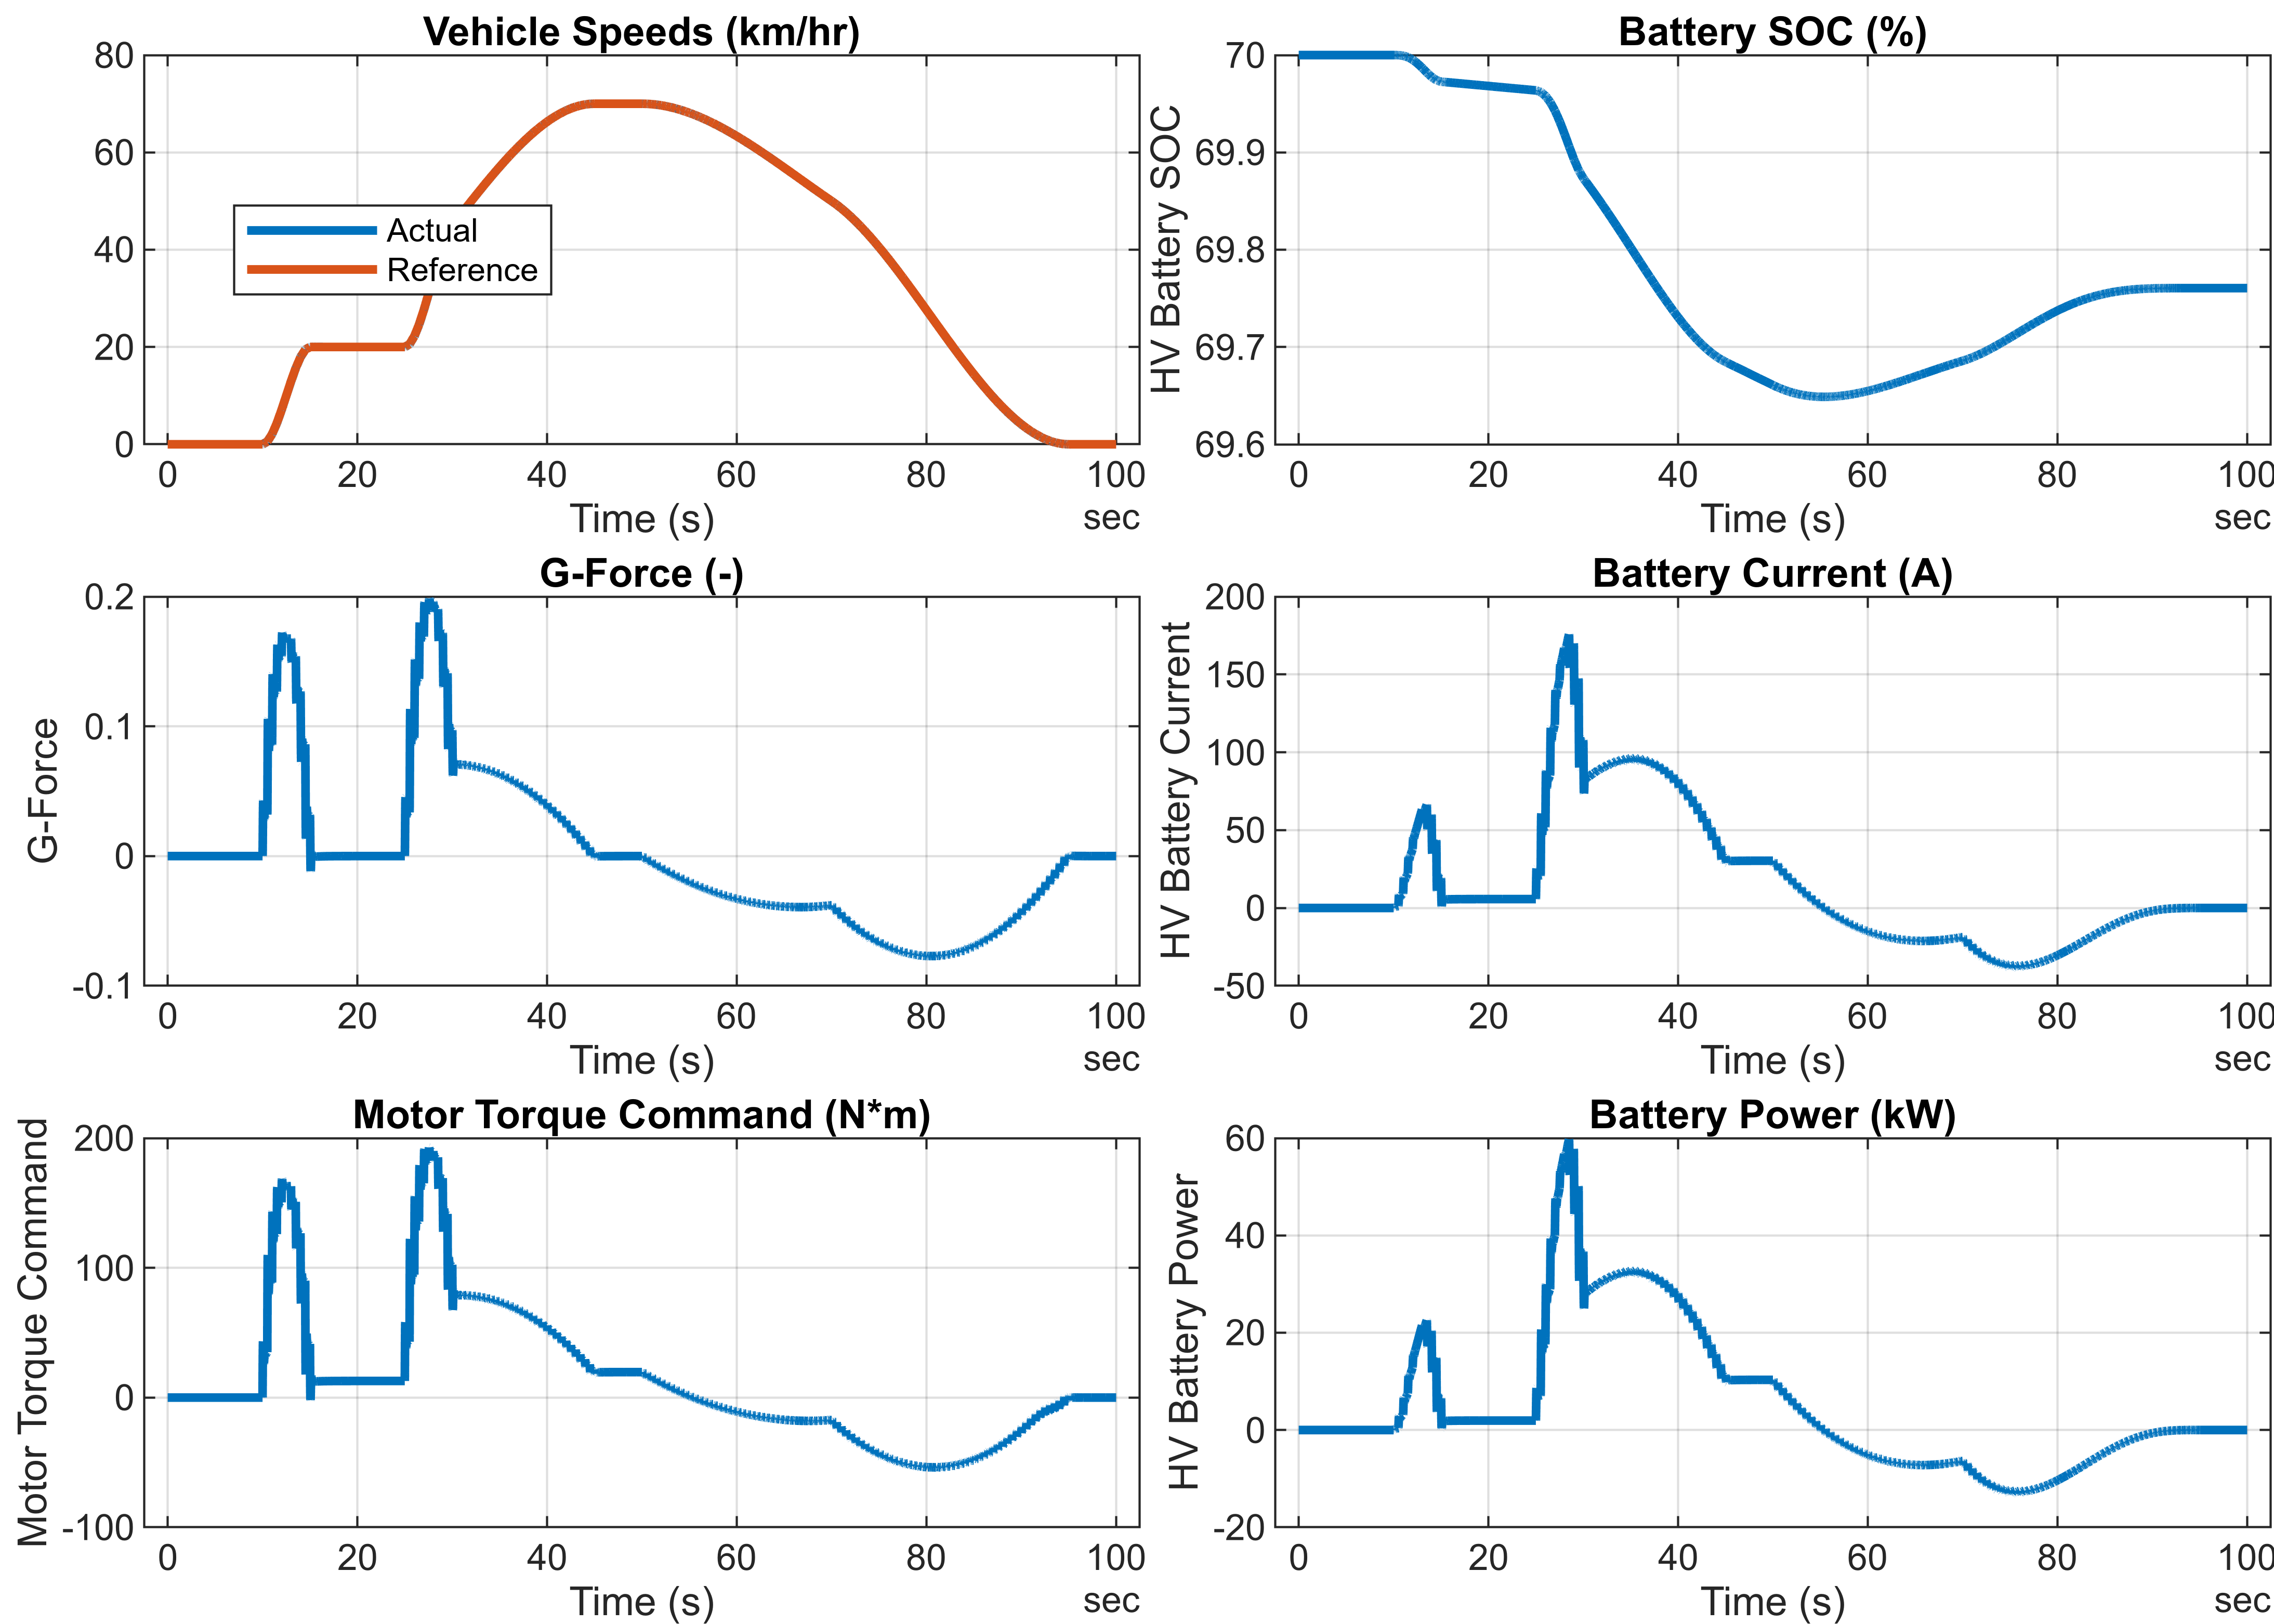

In [4]:
simOut = sim(modelName);
simData = extractTimetable(simOut.logsout);
fig = BEV_plotResultsCompact( SimData=simData, PlotTemperature=false );
% Save the plot to a PNG file.
prjRoot = currentProject().RootFolder;
imgFilename = "BEV_SimulationResultPlot.png";
exportgraphics(fig, fullfile(prjRoot, "BEV", "results", imgFilename))

<a name="H_EF7BCF44"></a>
## Save Result

Save logged signals to a CSV file for later analysis. CSV text format is used rather than binary format for saving the data. Text format works better when the data size is small and the file is version-managed with a source control tool such as git.


In [5]:
% Extract logged signals at once with extractTimetable.
simData = extractTimetable(simOut.logsout);

% Adjust time format so as not to lose the subsecond information.
simData.Time.Format = 'hh:mm:ss.SSSS';

% Signal names to save in file.
% These must be specified in the model as signal logging names.
% For example, in the BEV system model, see the Measurement subsystem.
dataColumns = [ ...
  "HV Battery SOC", "HV Battery Power", "HV Battery Current", ...
  "G-Force", "Vehicle Speed (km/hr)" ];

% Select the logged signals to save.
simData = simData(:, dataColumns);

% Add unit information to signal names.
varNames = string(simData.Properties.VariableNames');
% disp(varNames)
varUnits = string(simData.Properties.VariableUnits');
% disp(varUnits)
varNames2 = varNames + " (" + varUnits + ")";
disp(varNames2)

    "HV Battery SOC (%)"
    "HV Battery Power (kW)"
    "HV Battery Current (A)"
    "G-Force (1)"
    "Vehicle Speed (km/hr) (km/hr)"

In [6]:
simData.Properties.VariableNames = varNames2;

% Save data to CSV file.
simResultFilename  = "BEV_SimulationResult_1.csv";
simResultFile_FullPath = fullfile(prjRoot, "BEV", "results", simResultFilename);
writetimetable(simData, simResultFile_FullPath)


Open the saved CSV file in text editor and check that the variable names are saved at the first line as expected.

<a name="H_81E3C32A"></a>
## Analyse Result

This section reads a simulation result CSV file which was saved in the previous section, and do some analysis on the data. This section should work independently without running the previous section as long as the result file exists. At the end of this section, you get the electric efficiency of the vehicle according to the drive cycle for which the data was collected.


In [7]:
prjRoot = currentProject().RootFolder;
simResultFilename  = "BEV_SimulationResult_1.csv";
simResultFile_FullPath = fullfile(prjRoot, "BEV", "results", simResultFilename);

% Read a CSV file containing simulation result and store it to a timetable.
data = readtimetable(simResultFile_FullPath, VariableNamingRule="preserve");

% Adjust time format.
data.Time.Format = 's';

% Separate variable names and unit strings.
varNames_with_unit = data.Properties.VariableNames';
% disp(varNames_with_unit)
varNames = extractBefore(varNames_with_unit, " (");
disp(varNames)

    {'HV Battery SOC'    }
    {'HV Battery Power'  }
    {'HV Battery Current'}
    {'G-Force'           }
    {'Vehicle Speed'     }

In [8]:
varUnits = strings(5, 1);
for idx = 1 : numel(varNames_with_unit)
  % Return value from extractBetween is an N-by-1 cell array
  % for each varNames_with_unit where N could be different.
  % We keep the first element only,
  % we cannot assign them to varUnits at once outside for-loop.
  tmpUnits = extractBetween(varNames_with_unit{idx}, "(", ")");
  varUnits{idx} = tmpUnits{1};
end
disp(varUnits)

    "%"
    "kW"
    "A"
    "1"
    "km/hr"

In [9]:
data.Properties.VariableNames = varNames;
data.Properties.VariableUnits = varUnits;

% Define a little utility to manipulate the unit representation
% in Simscape's physical values.
tidyUnit = @(x,u) simscape.Value( value(x,u), u );


Time


In [10]:
t = simscape.Value( seconds(data.Time), 's' );
dt = diff(t);


Travelled Distance


In [11]:
dataVehSpd = data.("Vehicle Speed");
unitStr = varUnits(varNames == "Vehicle Speed");
vehicleSpeed = simscape.Value(dataVehSpd, unitStr{:});
averageSpeed = sum(vehicleSpeed)/numel(vehicleSpeed)

averageSpeed = 
   37.3941 : km/hr

In [12]:
maxSpeed = max(vehicleSpeed)

maxSpeed = 
   70.0078 : km/hr

In [13]:
tmpDistance = sum(vehicleSpeed(2:end).*dt);
travelledDistance = tidyUnit( tmpDistance, "km" )

travelledDistance = 
    0.9626 : km


G Force


In [14]:
G = data.("G-Force");
min(G), max(G)

ans = -0.0771
ans = 0.1985


Battery Power


In [15]:
dataBattPwr = data.("HV Battery Power");
unitStr = varUnits(varNames == "HV Battery Power");
batteryPower = simscape.Value(dataBattPwr, unitStr{:});  % J/s
batteryEnergyUsed = sum(batteryPower(2:end).*dt)

batteryEnergyUsed = 
  518.2296 : kW*s

In [16]:
batteryEnergyUsed = tidyUnit(batteryEnergyUsed, "kW*hr")

batteryEnergyUsed = 
    0.1440 : hr*kW

In [17]:
energyEfficiency_kWh_per_100km = 100 * value(batteryEnergyUsed / travelledDistance, "kW*hr/km")

energyEfficiency_kWh_per_100km = 14.9540


*Copyright 2022-2023 The MathWorks, Inc.*

